In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the field data

In [2]:
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/field_info/'
sys.path.append(path)
from field_grid import *
from format_field import get_field_df

In [3]:
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/field_info/data/'
file = "60Hr_Average_Comparison_all_3956_3997_norescut.txt"
# file = "60Hr_Average_Comparison_all_3956_3997_norescut_NoAvg.txt"
file = path + file
df_field = get_field_df(file)

# Get the muon/ctag data

In [4]:
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/muon_info'
sys.path.append(path)
from simple_ctags import get_ctags

In [5]:
data = get_ctags("2018-04-22 00:00:00", "2018-04-25 00:00:00",'localhost')
df_muons = pd.DataFrame.from_dict(data, orient="index",columns=['ctags'])
df_muons.index.name = 'DateTime'
df_muons.index = pd.to_datetime(df_muons.index)
df_muons = df_muons.sort_values(by=['DateTime'])

# combine field and muon/ctag data

In [6]:
#Get the muons/ctag time interval (shorter than the field's time interval)
muons_time_interval = (df_muons.index.values[1].astype('int64')
                      - df_muons.index.values[0].astype('int64'))//1e9

#upsample each dataframe to 1 second                      
df_muons = df_muons.resample('1S').ffill()
df_field = df_field.resample('1S').ffill()

#Join the dataframes
df_total = df_field.join(df_muons)
df_total = df_total.fillna(0)

#calculate ctags per second and add it as a column
factor = 1/float(muons_time_interval)
df_total['ctags_per_second'] = df_total['ctags'].astype(float)*factor

## get the ctag weighted field moments

In [7]:
total_ctags = df_total["ctags_per_second"].sum()
b = [
    (df_total["D"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["NQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["SQ"]*df_total["ctags_per_second"]).sum()/total_ctags,
    (df_total["NS"]*df_total["ctags_per_second"]).sum()/total_ctags
    ]

## get and plot the field grid based on the ctag weighted field moments

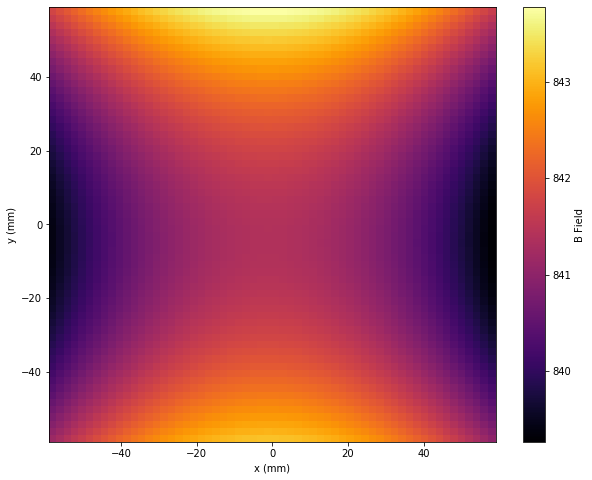

In [8]:
df_field_grid = get_field_grid(b)
fig = plot_field(df_field_grid)
fig

## also get and plot the field grid based on the time weighted field moments

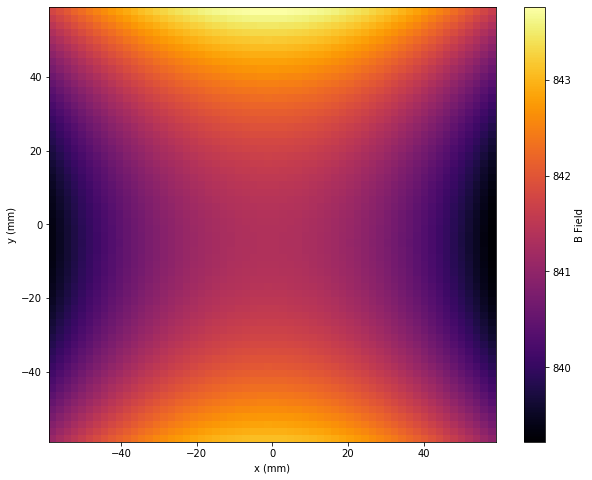

In [9]:
b_time = [
    df_total["D"].mean(),
    df_total["NQ"].mean(),
    df_total["SQ"].mean(),
    df_total["NS"].mean()]
df_field_grid_time = get_field_grid(b_time)
fig = plot_field(df_field_grid_time)
fig

## and plot the difference between the two field grids

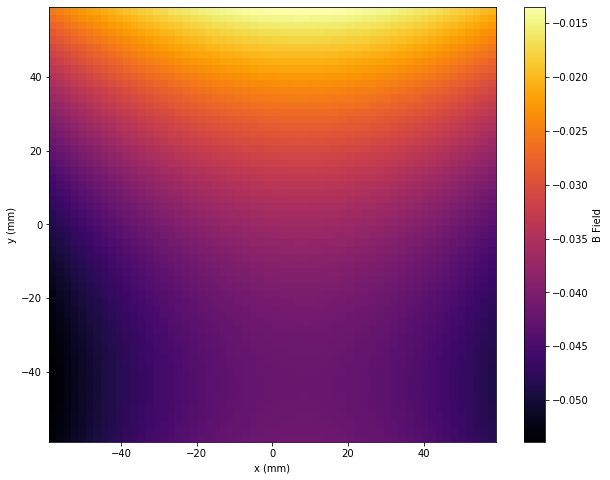

In [10]:
df_field_grid_time['diff'] = df_field_grid_time['B'] - df_field_grid['B']
fig = plot_field(df_field_grid_time,var='diff')
fig

# Get the tracker info

In [11]:
import sys
path='/Users/bono/Desktop/gm2FieldAnalysis/MuonConvolution/tracker_info'
sys.path.append(path)
from beam_moments import *
from transform_beam import *

__Plot the beam readout from two different tracker locations as well as the difference__

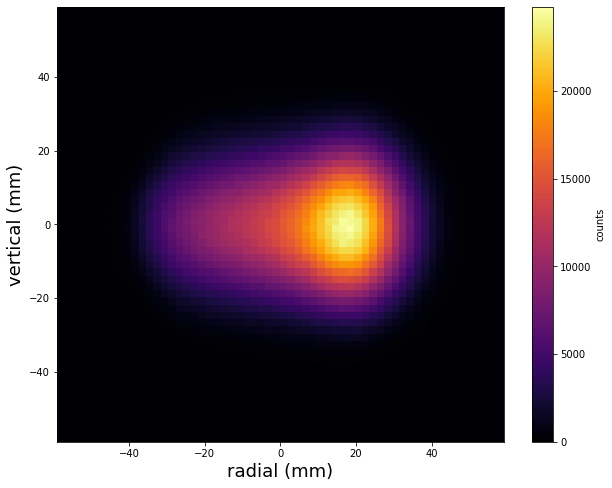

In [12]:
df_tracker = get_df_tracker()
#only look at station 12 or 18
mask12 = (df_tracker["Station"] == 'station12')
mask18 = (df_tracker["Station"] == 'station18')

df_12 = df_tracker[mask12].copy()
df_12['counts_norm'] = df_12['counts']/df_12['counts'].sum()
fig = plot_beam(df_12,bins=60)
fig
# df_12.head(6)

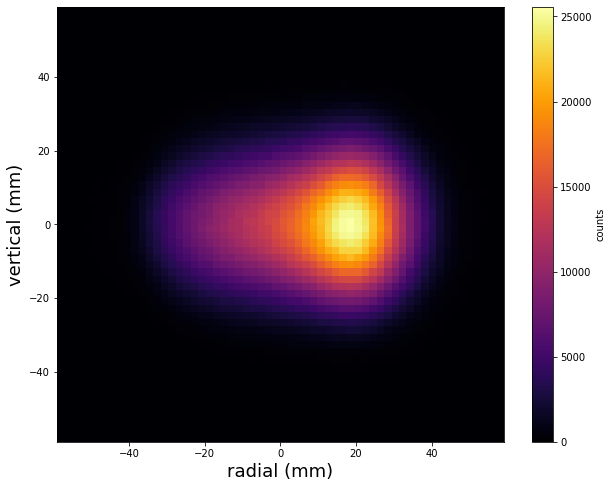

In [13]:
df_18 = df_tracker[mask18].copy()
df_18.reset_index(inplace=True)
df_18 = df_18.drop(columns=['level_0'])
df_18['counts_norm'] = df_18['counts']/df_18['counts'].sum()
fig = plot_beam(df_18,bins=60)
fig
# df_18.head(6)

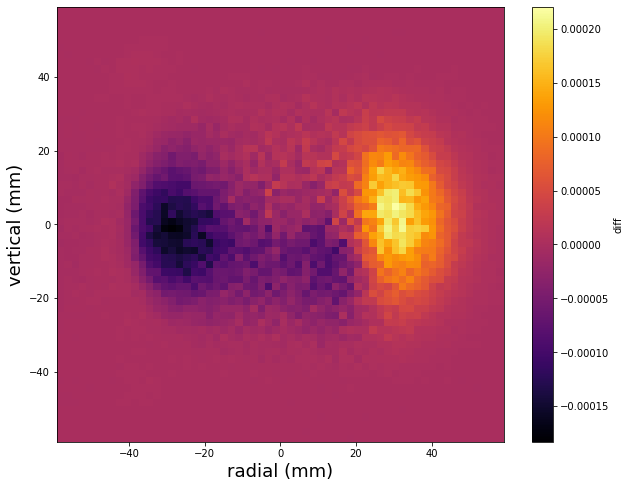

In [14]:
df_diff = pd.DataFrame()
df_diff['radial'] = df_12['radial']
df_diff['vertical'] = df_12['vertical']
df_diff['diff'] = (df_18['counts_norm'] -  df_12['counts_norm'])

fig = plot_beam(df_diff,bins=60,var='diff')
fig
# df_diff.head(6)

# Now get the difference-weighted B field  to see the size of the effect

In [15]:
#calculate the dipole
dipole = b[0]
#calculate the total field for the difference distribution
diff_field = (df_diff['diff']*df_field_grid['B']).sum()
diff_field

-0.012285498363805658

__so we see that the two stations produce a 12 ppb difference muon averaged B-field__

In a similar way, take the difference between the field as seen in the two stations.


also note that the muon averaged b field is invarient to the scale of the ctags:

In [16]:
field_12 = (df_12['counts']*df_field_grid['B']).sum()/(df_12['counts'].sum())
field_12

841.2667976859057

In [17]:
field_12 = (df_12['counts_norm']*df_field_grid['B']).sum()
field_12

841.2667976859057

In [18]:
field_18 = (df_18['counts_norm']*df_field_grid['B']).sum()
field_12
diff_field2 = field_18 - field_12
diff_field2

-0.012285498363780789

which is just about the same value as found in the alternate method:

In [19]:
diff_field - diff_field2

-2.4868995751603507e-14

# Now we can use an emulation to move the beam around to see the effect on the final muon-weighted average

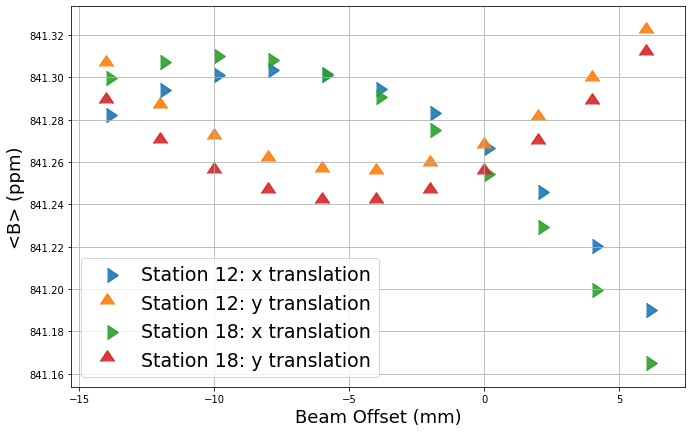

In [20]:
spacing = 2.001
low = -14
high=7
fig = plt.figure(figsize=(11,7))


#####Station 12########
B_arr = np.empty(0)
x_range = np.arange(low,high,spacing)
yshift = 0
for xshift in x_range:
    df = shift_beam(df_12,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.9, marker=9,
            label="Station 12: x translation",s=200)

B_arr = np.empty(0)
y_range = np.arange(low,high,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_12,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.9,marker=10,
            label="Station 12: y translation",s=200)

#####Station 18########
B_arr = np.empty(0)
x_range = np.arange(low,high,spacing)
yshift = 0
for xshift in x_range:
    df = shift_beam(df_18,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.9, marker=9,
            label="Station 18: x translation",s=200)

B_arr = np.empty(0)
y_range = np.arange(low,high,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_18,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.9,marker=10,
            label="Station 18: y translation",s=200)

plt.xlabel("Beam Offset (mm)",fontsize=18)
plt.ylabel("<B> (ppm)",fontsize=18)
plt.legend(prop={'size': 19})
plt.grid()
plt.show()

__So we see that vertical offsets about zero produces a $\pm$10 ppb effect for $\pm$ 2 mm of motion, and radial offsets about zero produces a $\pm$18 ppb effect for $\pm$ 2 mm of motion. This means that, if the uncertainty in the beam is 0.5 mm in both directions, then the very worst we can do is $\sqrt((18/4)^2 + (10/4)^2)$ = 5.1 ppb__

__Also note that there is 10 ppb difference between station 12 and station 18 when the offset is zero. if the simple average of the two stations was taken, then one could assign an uncertainty of $\pm$ 5ppb__



# Now we want to produce the same plot, but using a narrower/wider beam

Specifically, we want to subract the effect of detection off the beam. It has been shown in https://gm2-docdb.fnal.gov/cgi-bin/private/RetrieveFile?docid=18094&filename=2019_05_30_Tracker_Pitch.pdf&version=2
that the vertical and hoizantal resolution of the tracker is 3 mm, so this is what we want to subract.

In [21]:
df_narrow = df_12.copy()

df_narrow['counts']
w = df_narrow['counts']
v = df_narrow['vertical']
r = df_narrow['radial']
m_r = get_mean(r,w) #the radial mean
m_v = get_mean(v,w) #the vertical mean
rms_r = get_rms(r,m_r,w) #the radial rms
rms_v = get_rms(v,m_v,w) #the vertical rms

#first shift the beam
# df_narrow = shift_beam(df_narrow,-2.64,0)
#now narrow the beam
df_narrow = narrow(df_narrow,1.7,'counts','narrow')

w = df_narrow['narrow']
v = df_narrow['vertical']
r = df_narrow['radial']
m_r_new = get_mean(r,w) #the radial mean
m_v_new = get_mean(v,w) #the vertical mean
rms_r_new = get_rms(r,m_r_new,w) #the radial rms
rms_v_new = get_rms(v,m_v_new,w) #the vertical rms

print("original radial mean and rms:",m_r,rms_r)
print("original vertical mean and rms:",m_v,rms_v,'\n')

print("new radial mean and rms:",m_r_new,rms_r_new)
print("new vertical mean and rms:",m_v_new,rms_v_new,'\n')

print("radial change in mean and rms:",m_r_new - m_r,rms_r_new - rms_r)
print("vertical change in mean and rms:",m_v_new - m_v,rms_v_new - rms_v)


original radial mean and rms: 6.7936760480339125 18.256241636284077
original vertical mean and rms: -0.005800812143173988 12.805590974050983 

new radial mean and rms: 9.439720734489155 15.286170257105889
new vertical mean and rms: -0.14103951348483268 10.298741000142906 

radial change in mean and rms: 2.6460446864552427 -2.9700713791781883
vertical change in mean and rms: -0.1352387013416587 -2.5068499739080767


__So we see that the 'polynomial narrowing' reduced the radial and vertical rms by 2.9 and 2.5 mm respectivly, but also moved the mean radial position by over 2.5 mm. It would be better to do a gaussian deconvolution, but instead will accept the shift as an imperfection.__

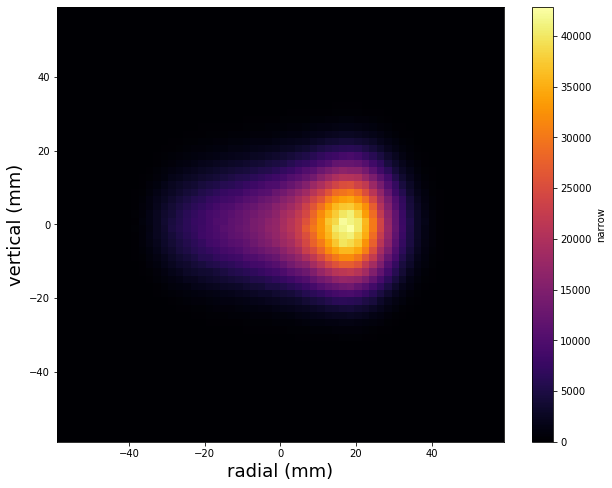

In [22]:
plot_beam(df_narrow,var='narrow')

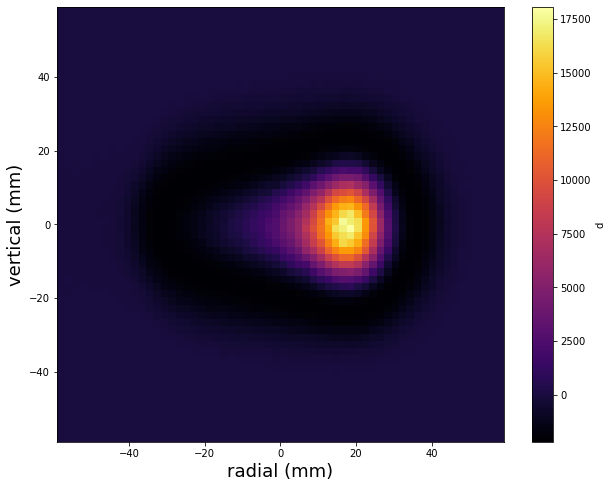

In [23]:
df_narrow['d'] = df_narrow['narrow'] - df_narrow['counts']
plot_beam(df_narrow,var='d')


# Also want to widen the beam

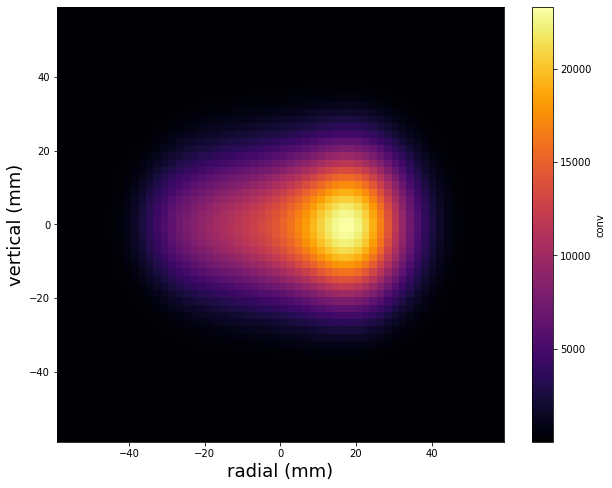

In [24]:
mask = df_tracker['Station'] == 'station12'
df_conv = df_12.copy()
c = convolve_df(df_conv,60,3)
df_conv['conv'] = c
plot_beam(df_conv,var='conv')

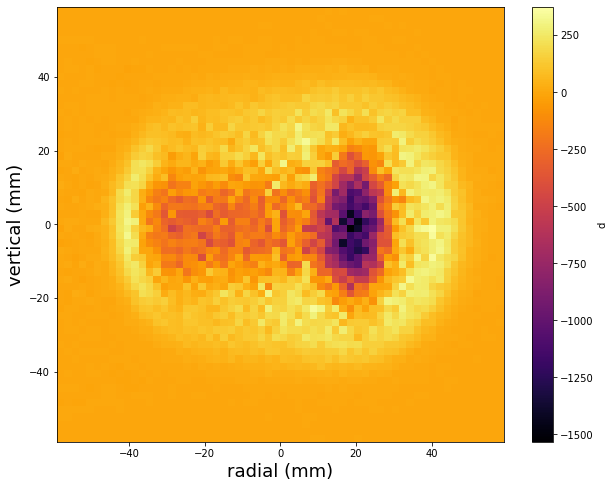

In [25]:
df_conv['d'] = df_conv['conv'] - df_conv['counts']
plot_beam(df_conv,var='d')

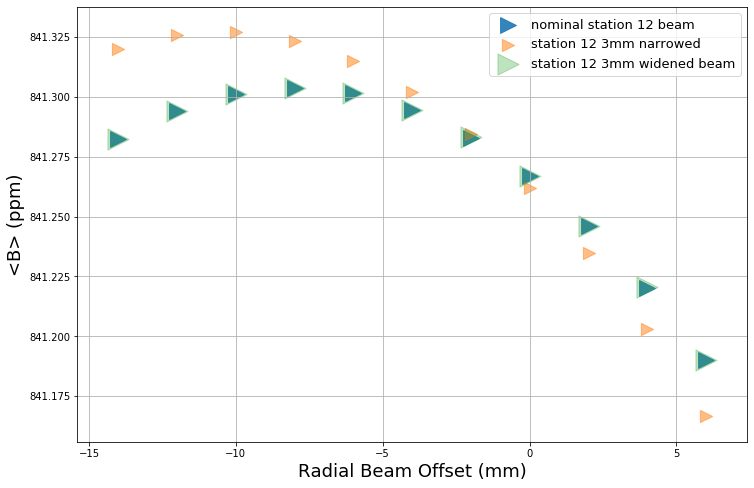

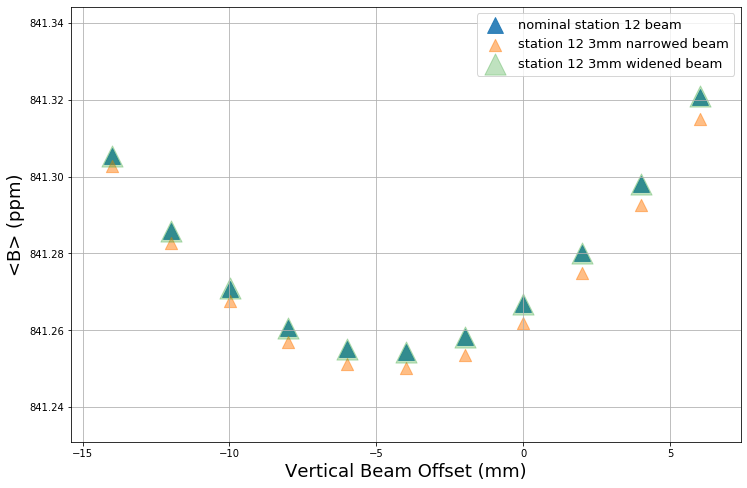

B_reg= 841.2667976859057 

B_wide= 841.2668314979117 

B_narrow= 841.2619596688726 

diff_wide= 3.3812005995059735e-05 

diff_narrow= -0.0048380170330801775


In [26]:
spacing = 2.001
low = -14
high=7
fig = plt.figure(figsize=(12,8))

#The regular beam
B_arr = np.empty(0)
x_range = np.arange(low,high,spacing)
yshift = 0
for xshift in x_range:
    df = shift_beam(df_12,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.9, marker=">",s=250,
            label="nominal station 12 beam")






##narrowed beam
df_narrow['counts'] = df_narrow['narrow']
yshift = 0
x_range = np.arange(low,high,spacing)
B_arr = np.empty(0)
for xshift in x_range:
    df = shift_beam(df_narrow,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.5, marker=">",s=150,
            label="station 12 3mm narrowed")



#widened beam
df_conv['counts'] = df_conv['conv']
yshift = 0
x_range = np.arange(low,high,spacing)
B_arr = np.empty(0)
for xshift in x_range:
    df = shift_beam(df_conv,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(x_range, B_arr, alpha=0.3, marker=">",s=450,
            label="station 12 3mm widened beam")


plt.xlabel("Radial Beam Offset (mm)",fontsize=18)
plt.ylabel("<B> (ppm)",fontsize=18)
plt.legend(prop={'size': 13})
plt.grid()
plt.show()


######################################

fig = plt.figure(figsize=(12,8))


B_arr = np.empty(0)
y_range = np.arange(low,high,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_12,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.9,marker="^",s=250,
            label="nominal station 12 beam")



B_arr = np.empty(0)
y_range = np.arange(low,high,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_narrow,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.5,marker="^",s=150,
            label="station 12 3mm narrowed beam")





B_arr = np.empty(0)
y_range = np.arange(low,high,spacing)
xshift = 0
for yshift in y_range:
    df = shift_beam(df_conv,xshift,yshift)
    B = (df['counts']*df_field_grid['B']).sum()/(df['counts'].sum())
    B_arr = np.append(B_arr,B)
plt.scatter(y_range, B_arr, alpha=0.3,marker="^",s=450,
            label="station 12 3mm widened beam")




plt.xlabel("Vertical Beam Offset (mm)",fontsize=18)
plt.ylabel("<B> (ppm)",fontsize=18)
plt.legend(prop={'size': 13})
plt.grid()
plt.show()



B_reg = (df_12['counts']*df_field_grid['B']).sum()/(df_12['counts'].sum())
B_narrow = (df_narrow['narrow']*df_field_grid['B']).sum()/(df_narrow['narrow'].sum())
B_wide = (df_conv['conv']*df_field_grid['B']).sum()/(df_conv['conv'].sum())
diff_narrow = B_narrow - B_reg
diff_wide = B_wide - B_reg
print('B_reg=',B_reg,'\n')
print('B_wide=',B_wide,'\n')
print('B_narrow=',B_narrow,'\n')
print('diff_wide=',diff_wide,'\n')
print('diff_narrow=',diff_narrow)



__First, we see that the difference between the 3 sigma narrowed beam has a muon weighted average that is less than the nominal beam. The total shift at zero is about -5 ppb, whereas the wider distribution shows that broadening at the 3 sigma level produces a +0.3 ppb shift. The magnitude of the broadening result is probably a better estimate of the effect of true gaussian deconvolution, rather than the polynomial narrowing. We can therefore say that the result from narrowing would shift the results downward by between -5 and -0.3, where the true result is probably somewhere close to -1 ppb, which we will take as nominal__

__We also see that the narrowed beam is more sensitive to radial offsets we get roughly $\pm$ 26 ppb change in result from $\pm$ 2 mm radial offset, whereas the vertical offset of $\pm$ 2 mm still results in 10 ppm. This means, if the true beam is narrowed by 3 mm from what the tracker observes, and the beam position uncertainty is 0.5 mm, then the radial contribution is 6.5 ppb and the 2.5 ppb, giving a total uncertainty from beam position uncertainty of of about 7 ppb, up from 5.1 ppb from the nominal beam's motion__

# A closer look at a plot of muon averaged result vs tracker broadening 

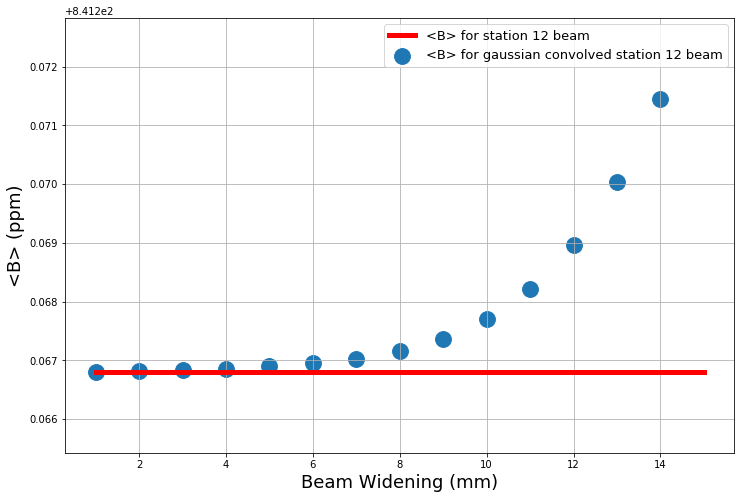

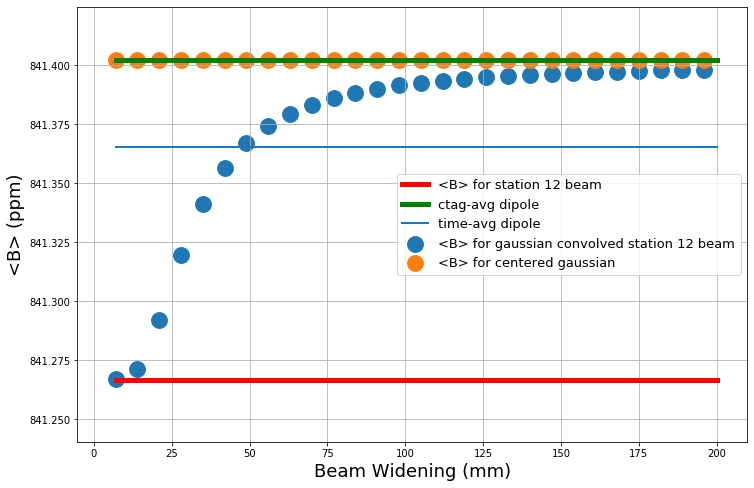

In [27]:

mask = df_tracker['Station'] == 'station12'
df_conv = df_tracker[mask].copy()

spacing_list = [1,7]
high_list = [15,200]

for i in range(len(spacing_list)):
    fig = plt.figure(figsize=(12,8))
    spacing = spacing_list[i]
    high = high_list[i]
    B_arr = np.empty(0)
    sigmas = np.arange(spacing,high,spacing)
    for sigma in sigmas:
        c = convolve_df(df_conv,60,sigma)
        df_conv['conv'] = c
        df_conv['conv'] = df_conv['conv']
        B = (df_conv['conv']*df_field_grid['B']).sum()/(df_conv['conv'].sum())
        B_arr = np.append(B_arr,B)
    if(i==0):
        axes = plt.gca()
        axes.set_ylim([np.amin(B_arr) - np.std(B_arr),np.amax(B_arr) + np.std(B_arr)])
    plt.scatter(sigmas, B_arr,marker="o",
                s=250,label='<B> for gaussian convolved station 12 beam')


    #B for the regular beam
    B = (df_conv['counts']*df_field_grid['B']).sum()/(df_conv['counts'].sum())
    plt.plot([spacing, high], [B, B], 
             linestyle='-', linewidth=5, color='red',label='<B> for station 12 beam')


    #B for the regular beam, but with the time-averaged field
   # B = (df_conv['counts']*df_field_grid_time['B']).sum()/(df_conv['counts'].sum())
   # plt.plot([spacing, high], [B, B], 
   #          linestyle='-', linewidth=5, color='c',label='<B> for station 12 beam, using time-averaged field')



    if(i==1):
        #do the same with a centered gaussian beam
        B_arr = np.empty(0)
        sigmas = np.arange(spacing,high,spacing)
        for sigma in sigmas:
            g = gaussian_kernel(59,sigma)
            g = np.reshape(g, (60*60),-1)
            df_conv['gaus'] = g
            B = (df_conv['gaus']*df_field_grid['B']).sum()/(df_conv['gaus'].sum())
            B_arr = np.append(B_arr,B)
        plt.scatter(sigmas, B_arr,marker="o",
                    s=250, label='<B> for centered gaussian')


        


        #Just the ctag weighted dipole
        D = (df_total["D"]*df_total["ctags_per_second"]).sum()/df_total["ctags_per_second"].sum()
        plt.plot([spacing, high], [D, D], 
                 linestyle='-', linewidth=5, color='green',label='ctag-avg dipole')


#         Just the time-weighted dipole
        D = df_total["D"].mean()
        plt.plot([spacing, high], [D, D], 
                 linestyle='-', linewidth=2,label='time-avg dipole')
        


    
    
    plt.xlabel("Beam Widening (mm)",fontsize=18)
    plt.ylabel("<B> (ppm)",fontsize=18)
    plt.grid()
    plt.legend(prop={'size': 13})
    plt.show()
    

__From the top plot, we see that it takes about 10 mm of gaussian broadening to produce a 1ppb effect, but we have already treated broadening/narrowing regarding shifts and systematics.__

__The bottom plot shows that, as the station 12 beam is gaussian broadened, the effects of the multipole moments wash out, leaving only the dipole, as expected.__

__The bottom plot also shows that a pure, azimuthally symetric, gaussian beam, centered on zero is unaffected by multipole moments, regarless of the width, as expected.__

__Finally, the bottom plot shows that the difference between the time averaged and CTAG averaged dipole is roughly 35 ppb, whereas the difference between time averaged and CTAG averaged full fields (using station 12 beam) is also roughly 35 ppb__

# Summary:

* Using using CTAGs over time weighted averaging results in a higher average field of __+35 ppb__, mostly due to a shift in the dipole. There is also a fairly large shift in the dominance of the skew quadrupole, but this does not affect the results much because the muon beam is well-centered vertically. 
    * This magnitude is expected to change with the incorperation of filters based on quality flags
* Given the field, difference between the muon beam as measured by tracker station 18 and 12 is __+10 ppb__, which, if the two results were averaged, would result in an uncertainty of __$\pm$ 5 ppb__
* If the detector of 3mm resolution is removed, it's estimated that it would shift the results by between -5 and -0.3 ppb, with the lower number being more probable. we therefore assign a shift of __-1 ppb__ due to the intrinsic tracker resolution
* Using the narrowed beam, we estimated that sensitivity to a random shift in both x and y together results in an uncertainty of __$\pm$ 7 ppb per 0.5 mm__ 
    * note that if the nominal beam is used, this uncertainty is $\pm$ 5 ppb per 0.5 mm
* The difference between using the beam as read out by the tracker, and a simple centered beam is __-140 ppb__